# Chapter 3. Path Tracing Ver. 0.6 - Direct Illumination: Homework

### Initialize

In [1]:
from enum import Enum
from time import time
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import drjit as dr
import mitsuba as mi

from util import imshow_compare, imshow_compare_many

mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')
print(f"{mi.MI_VERSION = }")
print(f"{mi.variant() = }\n")

cbox1_dict = mi.cornell_box()
cbox2_dict = mi.cornell_box()
cbox1_dict['integrator']['max_depth'] = 2
cbox1_dict['sensor']['film']['rfilter']['type'] = 'box'
cbox2_dict['integrator']['max_depth'] = 2
cbox2_dict['sensor']['film']['rfilter']['type'] = 'box'
cbox1_dict['sensor']['film']['width'] = 32
cbox1_dict['sensor']['film']['height'] = 32
cbox1_dict['sensor']['sampler']['sample_count'] = 4

cbox1_scene = mi.load_dict(cbox1_dict)
cbox2_scene = mi.load_dict(cbox2_dict)
print(f"{type(cbox1_scene) = }")

vmis_scene = mi.load_file("./scene/veach-mis/scene.xml")

mi.MI_VERSION = '3.6.0'
mi.variant() = 'cuda_ad_rgb'

type(cbox1_scene) = <class 'mitsuba.Scene'>


### See GT

In [2]:
t0 = time()
img_gt1 = mi.render(cbox1_scene, spp=1024)
print(f"Render time for cbox1: {time() - t0:.4f} s.")

t0 = time()
img_gt2 = mi.render(cbox2_scene, spp=1024)
print(f"Render time for cbox2: {time() - t0:.4f} s.")

t0 = time()
img_gt3 = mi.render(vmis_scene, spp=1024)
print(f"Render time for Veach MIS: {time() - t0:.4f} s.")

Render time for cbox1: 0.0340 s.
Render time for cbox2: 0.0442 s.
Render time for Veach MIS: 0.0180 s.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.7363765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..3.7564507].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..38.291386].


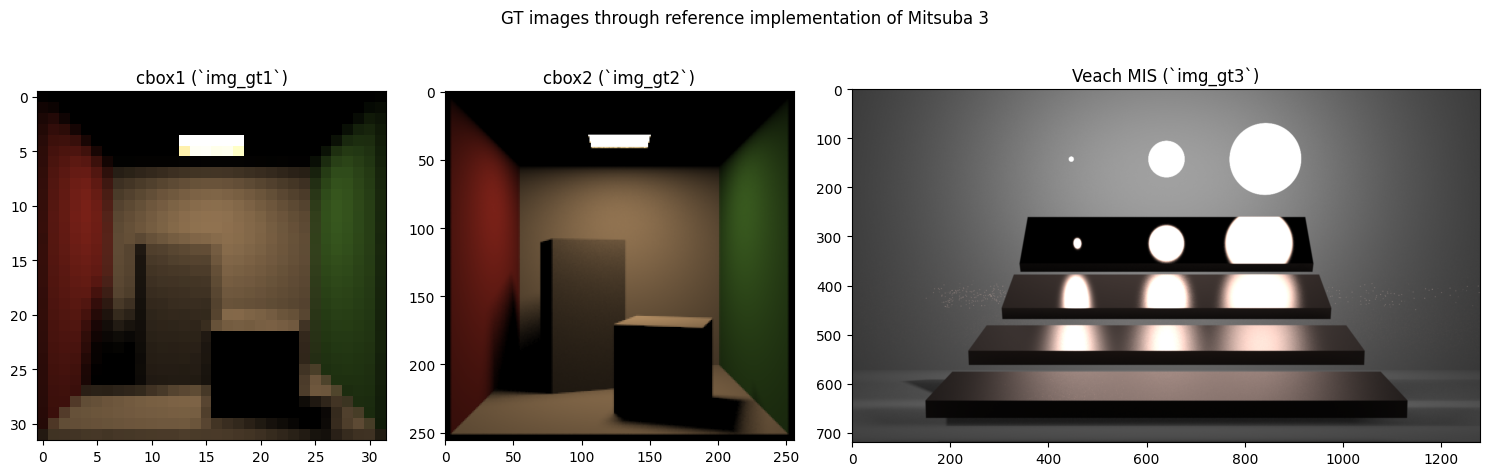

In [3]:
fig, axes = plt.subplots(1, 3,
                         figsize=(15, 5),
                         gridspec_kw={'width_ratios':  [1, 1, 1.8]}
                        )
axes[0].imshow(mi.Bitmap(img_gt1**(1/2.2)))
axes[0].set_title("cbox1 (`img_gt1`)")
axes[1].imshow(mi.Bitmap(img_gt2**(1/2.2)))
axes[1].set_title("cbox2 (`img_gt2`)")
axes[2].imshow(mi.Bitmap(img_gt3**(1/2.2)))
axes[2].set_title("Veach MIS (`img_gt3`)")
fig.suptitle("GT images through reference implementation of Mitsuba 3");
plt.tight_layout()

-----
## Ver. 0.1 Normal Integrator: sampling primary rays

In [4]:
seed = 0
spp = 4
sensor = cbox1_scene.sensors()[0]
film = sensor.film()
sampler = sensor.sampler().clone()
film_size = film.size()
wavefront_size = dr.prod(film_size) * spp
sampler.seed(seed, wavefront_size)

idx = dr.arange(mi.UInt32, wavefront_size)
idx //= spp

pos = mi.Vector2i()
pos.y = idx // film_size[0]
pos.x = dr.fma(mi.Int32(-film_size[0]), pos.y, idx)
pos_f = mi.Vector2f(pos) + sampler.next_2d()

pos_adjusted = pos_f / mi.ScalarVector2f(film_size)

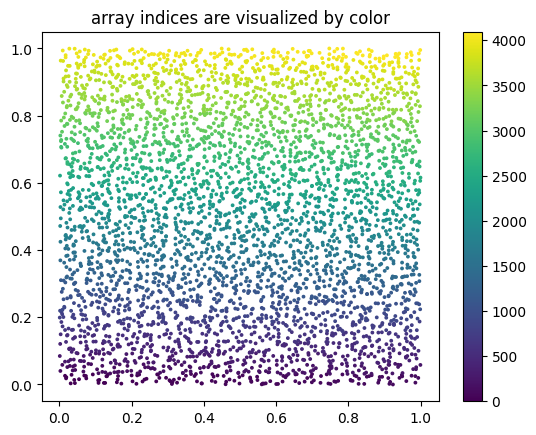

In [5]:
def visualize_imgcoords(val: mi.Vector2f):
    sc = plt.scatter(val.x, val.y, c=dr.arange(mi.UInt32, dr.shape(val)[1]), s=3.0)
    plt.colorbar(sc)
    plt.title("array indices are visualized by color")
    plt.show()
visualize_imgcoords(pos_adjusted)

In [6]:
ray, _ = sensor.sample_ray(time=0, sample1=0, sample2=pos_adjusted, sample3=0)
print(ray)

Ray[
  o=[[-0.000346053, 0.000338611, 3.899],
     [-0.000343961, 0.000344141, 3.899],
     [-0.000343478, 0.000341692, 3.899],
     [-0.000334851, 0.000354792, 3.899],
     [-0.000318319, 0.000345909, 3.899],
        4086 skipped ..,
     [0.000329371, -0.000338485, 3.899],
     [0.000339682, -0.000343159, 3.899],
     [0.000338039, -0.000349025, 3.899],
     [0.000356563, -0.000353822, 3.899],
     [0.000353875, -0.00034658, 3.899]],
  d=[[-0.311467, 0.30477, -0.900057],
     [-0.309293, 0.309455, -0.899208],
     [-0.30911, 0.307503, -0.899941],
     [-0.300947, 0.318869, -0.898751],
     [-0.288077, 0.313045, -0.904994],
        4086 skipped ..,
     [0.297825, -0.306067, -0.904225],
     [0.305891, -0.309022, -0.90052],
     [0.304048, -0.313929, -0.899446],
     [0.318623, -0.316174, -0.893596],
     [0.317106, -0.310569, -0.896097]],
  maxt=[111.103, 111.208, 111.117, 111.264, 110.497,    4086 skipped .., 110.591, 111.046, 111.178, 111.906, 111.594],
  time=[0],
  wavelengths=[]

In [7]:
def sample(scene: mi.Scene, sampler: mi.Sampler, ray: mi.Ray3f):
    si = scene.ray_intersect(ray)
    return si.n

In [8]:
L = sample(cbox1_scene, sampler, ray)
print(L)

[[0, 0, 0],
 [0, -1, -4.37114e-08],
 [1, 0, -4.37114e-08],
 .. 4090 skipped ..,
 [0, 0, 0],
 [0, 0, 0],
 [0, 0, 0]]


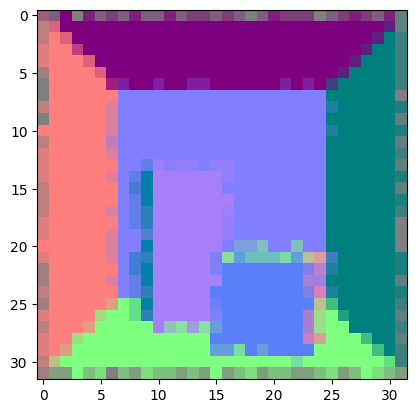

In [10]:
image = L.numpy().T.reshape(tuple(film_size) + (spp, 3)).mean(2)
plt.imshow(image*0.5+0.5); # Mapping noraml vectors in [-1, 1]^3 into RGB color space [0, 1]^3

In [11]:
def render_normal(scene: mi.Scene, spp: Optional[int] = 4, seed: Optional[int] = 0):
    #################### TODO start ####################
    """ ... """
    sensor = scene.sensors()[0]
    film = sensor.film()
    film_size = film.size()
    """ ... """

    image = np.zeros(tuple(film_size) + (3,))
    #################### TODO end ####################
    return image

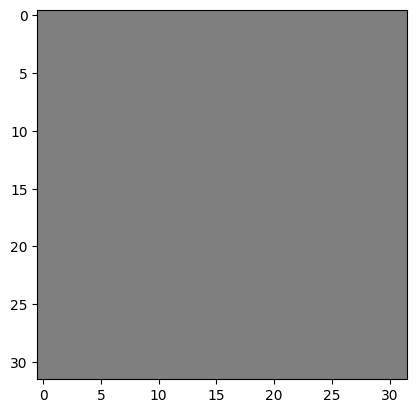

In [12]:
image = render_normal(cbox1_scene, spp=1024)
plt.imshow(image*0.5+0.5);

<class 'drjit.cuda.ad.TensorXf'>
normal_GT_np.shape = (32, 32, 6)


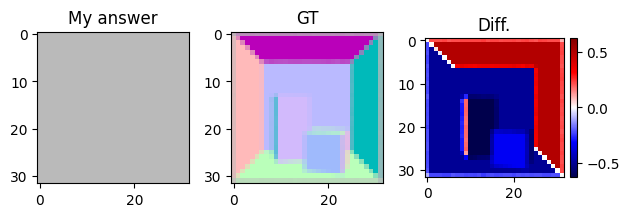

In [13]:
normal_integrator = mi.load_dict(
    {'type': 'aov',
    'aovs': 'nn:sh_normal',
    'my_image': {
        'type': 'direct',
    }})
normal_GT = mi.render(cbox1_scene, spp=1024, integrator=normal_integrator)
print(type(normal_GT))
normal_GT_np = normal_GT.numpy()
print(f"{normal_GT_np.shape = }")

# plt.imshow(normal_GT_np[:,:,3:]*0.5+0.5)
imshow_compare(image*0.5+0.5, normal_GT_np[:,:,3:]*0.5+0.5);

-----
## Ver. 0.2 Normal Integrator inheriting `mitsuba.Integrator`

In [14]:
class NormalIntegrator(mi.ad.integrators.common.ADIntegrator):
    def __init__(self, props = mi.Properties()):
        super().__init__(props)
    
    def sample(self,
               mode: dr.ADMode, # NOT USED NOW (differentiable rendering)
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               active: mi.Bool,
               **kwargs # Absorbs unused arguments
               ):
        si = scene.ray_intersect(ray)
        return si.n, active, [], None
    
mi.register_integrator("normal", lambda props: NormalIntegrator(props)) # Try to uncomment

In [15]:
t0 = time()
for i in range(10):
    image = mi.render(cbox1_scene, spp=1024, integrator=NormalIntegrator())
    image.numpy()
print(f"Elapsed time: {time() - t0} s.")

Elapsed time: 0.03210282325744629 s.


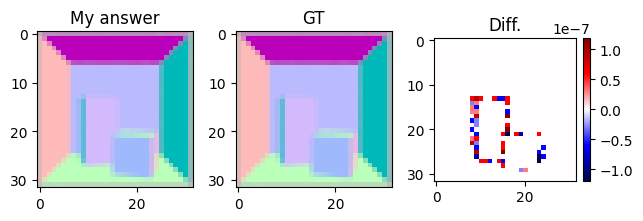

In [16]:
image = mi.render(cbox1_scene, spp=1024, integrator=NormalIntegrator())
imshow_compare(image*0.5+0.5, normal_GT_np[:,:,3:]*0.5+0.5);

Note that `mi.register_integrator()` makes us use our custom plugins (integrator, here) in XML or dictionary scene representation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920929e-07..1.0000002].


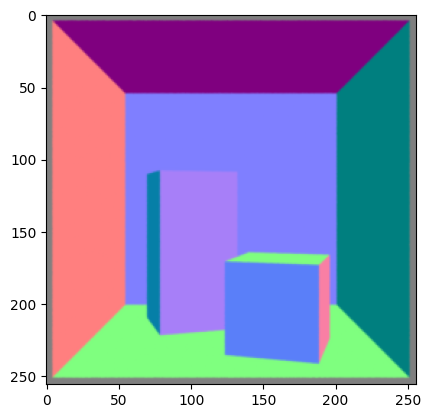

In [17]:
cbox_dict_temp = mi.cornell_box()
cbox_dict_temp['integrator'] = {'type': 'normal'}
scene_temp = mi.load_dict(cbox_dict_temp)
plt.imshow(mi.render(scene_temp)*0.5+0.5);

-----
## Ver. 0.3 Direct Illumination Integrator using BSDF sampling

In [18]:
class PTSamplingMode(Enum):
    BSDF = 0  # Ver 0.3
    LIGHT = 1 # Ver 0.4
    MIS = 2   # Ver 0.5 Multiple Importance Sampling

class DirectIntegrator(mi.ad.integrators.common.ADIntegrator):
    def __init__(self, props = mi.Properties()):
        super().__init__(props)
        self.sampling_mode = PTSamplingMode(props.get('sampling_mode', 0))
    
    def sample(self,
               mode: dr.ADMode, # NOT USED NOW (differentiable rendering)
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               active: mi.Bool,
               **kwargs # Absorbs unused arguments
               ):
        #################### TODO start ####################
        L = mi.Spectrum(0)
        #################### TODO end ####################
        return L, active, [], None

Elapsed time for rendering and showing: 0.0795 s.


<Figure size 1000x300 with 0 Axes>

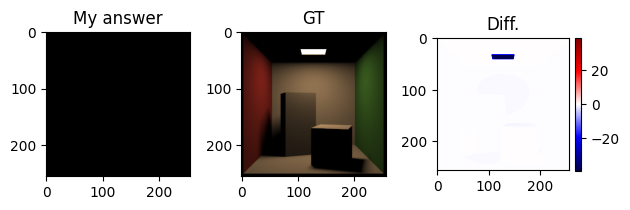

In [19]:
spp = 1024 # Try to change
t0 = time()
image = mi.render(cbox2_scene, integrator=DirectIntegrator(), spp=spp)
plt.figure(figsize=(10,3))
imshow_compare(image, img_gt2)
print(f"Elapsed time for rendering and showing: {time()-t0:.4f} s.")

Elapsed time for rendering and showing: 0.1540 s.


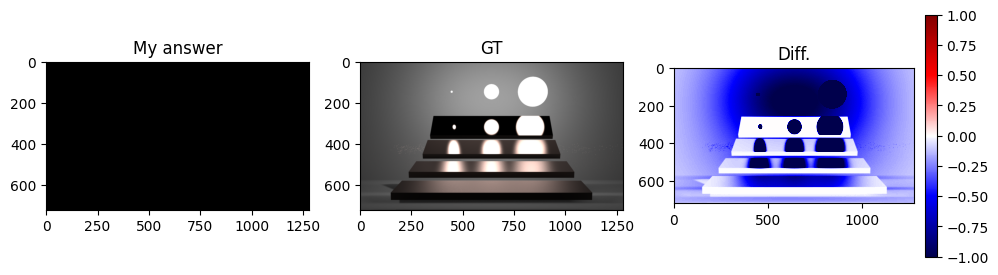

In [20]:
spp = 1 # Try to change
t0 = time()
image = mi.render(vmis_scene, integrator=DirectIntegrator(), spp=spp, seed=0)
imshow_compare(image, img_gt3, vabs=1, figsize=(10,3))
print(f"Elapsed time for rendering and showing: {time()-t0:.4f} s.")

-----
## Ver. 0.4 Direct Illumination Integrator using Emitter sampling

In [21]:
class DirectIntegrator(mi.ad.integrators.common.ADIntegrator):
    def __init__(self, props = mi.Properties()):
        super().__init__(props)
        self.sampling_mode = PTSamplingMode(props.get('sampling_mode', 0))
    
    def sample(self,
               mode: dr.ADMode, # NOT USED NOW (differentiable rendering)
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               active: mi.Bool,
               **kwargs # Absorbs unused arguments
               ):
        #################### TODO start ####################
        L = mi.Spectrum(0)
        #################### TODO end ####################
        return L, active, [], None

mi.register_integrator("mydirect", lambda props: DirectIntegrator(props))

Elapsed time for rendering and showing: 0.0683 s.


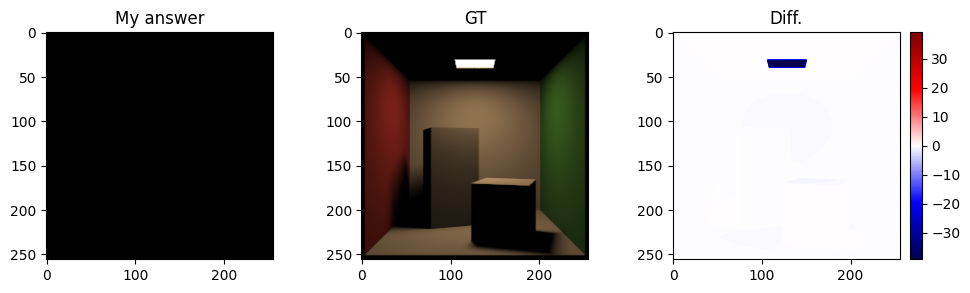

In [22]:
spp = 1024 # Try to change
t0 = time()
image = mi.render(cbox2_scene,
                  integrator=mi.load_dict({'type': 'mydirect', 'sampling_mode':1}),
                  spp=spp)
imshow_compare(image, img_gt2, figsize=(10,3))
print(f"Elapsed time for rendering and showing: {time()-t0:.4f} s.")

-----
## Ver. 0.4 Direct Illumination Integrator using Multiple Importance Sampling

Another scene: *Veach MIS*

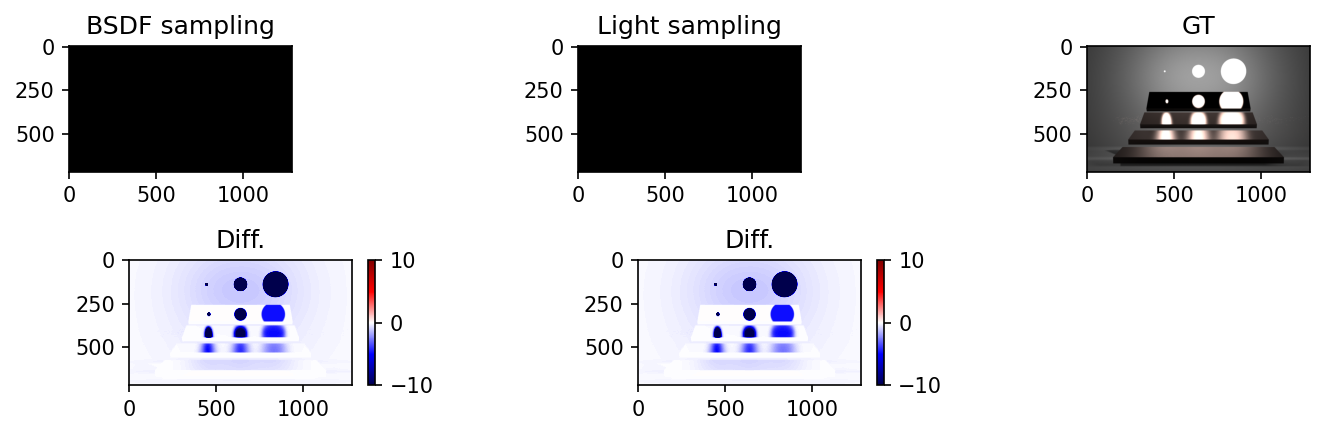

In [23]:
spp = 16 # Try to change
images = []
for i in range(2):
    img = mi.render(vmis_scene,
                    integrator=mi.load_dict({'type': 'mydirect', 'sampling_mode': i}),
                    spp=spp)
    images.append(img)
plt.figure(figsize=(10,3), dpi=150)
imshow_compare_many(images, img_gt3,
                    ["BSDF sampling", "Light sampling"], "GT",
                    vabs=10)

In [24]:
class DirectIntegrator(mi.ad.integrators.common.ADIntegrator):
    def __init__(self, props = mi.Properties()):
        super().__init__(props)
        self.sampling_mode = PTSamplingMode(props.get('sampling_mode', 0))
    
    def sample(self,
               mode: dr.ADMode, # NOT USED NOW (differentiable rendering)
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               active: mi.Bool,
               **kwargs # Absorbs unused arguments
               ):
        #################### TODO start ####################
        L = mi.Spectrum(0)
        #################### TODO end ####################
        return L, active, [], None
    
    def mis_weight(self, pdf_a, pdf_b):
        #################### TODO start ####################
        w = 0
        #################### TODO end ####################
        return dr.select(dr.isfinite(w), w, 0)

mi.register_integrator("mydirect", lambda props: DirectIntegrator(props))

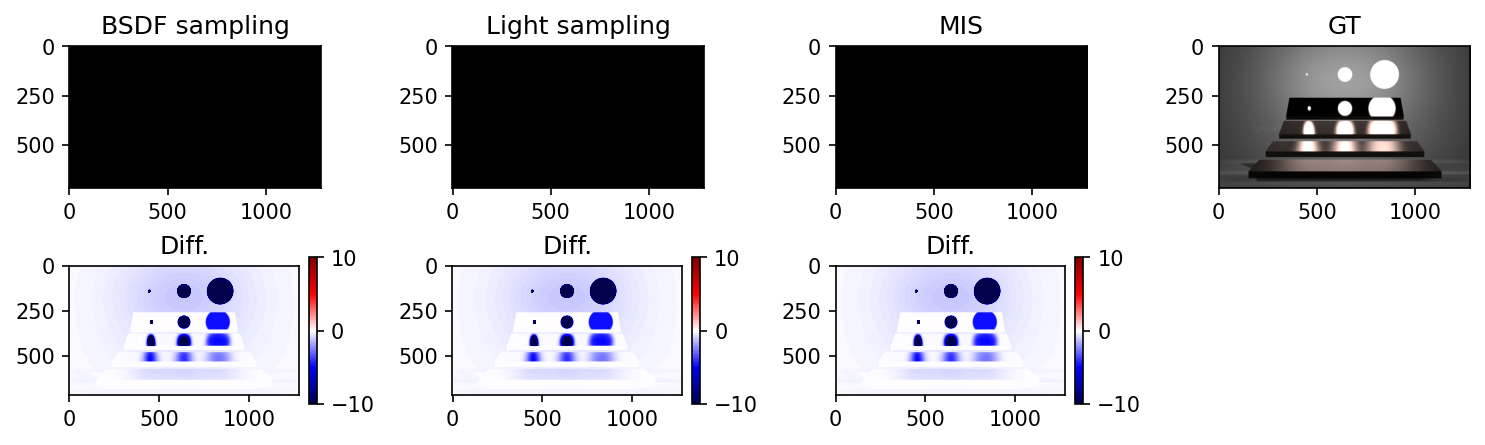

In [25]:
spp = 16 # Try to change
images = []
for i in range(3):
    img = mi.render(vmis_scene,
                    integrator=mi.load_dict({'type': 'mydirect', 'sampling_mode': i}),
                    spp=spp)
    images.append(img)
plt.figure(figsize=(10,3), dpi=150)
imshow_compare_many(images, img_gt3,
                    ["BSDF sampling", "Light sampling", "MIS"], "GT",
                    vabs=10)

-----
***TODO:***
* Russian Roulette for path termination
* Mitsuba 3 implementation techniques: `active` mask and `mi.Loop`
* generic consideration for Dirac delta distributions (specular, point light)